<a href="https://colab.research.google.com/github/Ravio1i/ki-lab/blob/master/0_Simple_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple Neural Network with PyTorch. Original source can be found [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

In [1]:
import torch
import torch.nn.functional as F
from torch import optim 
import torchvision
import matplotlib.pyplot as plt
from time import time
print(torch.__version__)
print(torchvision.__version__)

1.8.0+cu101
0.9.0+cu101


# Network
TwoLayerNet with configurable activation function

In [2]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, activation_function: F.log_softmax):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, output_size)
        self.activation_function = F.log_softmax

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # Relu von pytorch
        h_relu = F.relu(self.linear1(x))
        #h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return self.activation_function(y_pred)

# DATA LOADER

Using QMNIST, because MNIST is not reachable

In [3]:
#!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
#!tar -zxvf MNIST.tar.gz
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.QMNIST('/files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((0.1307,), (0.3081,))
                              ])),
    batch_size=batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.QMNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True
)

# Preprocessing

Showing the data size and sample data

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

torch.Size([1000, 1, 28, 28])


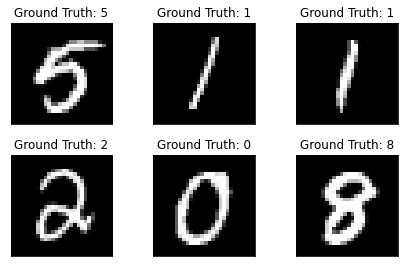

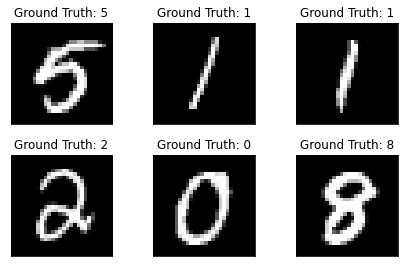

In [5]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [6]:
# get data and labels from train_loader
x, y = next(iter(train_loader))
print(x.shape)
# Flatten tensor
print(x.view(x.shape[0], -1).shape)
#print(x.flatten().shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 784])


# Train
Method to train the model with configurable parameters

In [7]:
def train(model, epoch: int, loss_function: torch.nn.functional, optimizer: torch.optim, device: torch.device, log_interval: int = 100):
    """Forward pass: Compute predicted y by passing x to the model
    """ 
    global train_losses, train_counter

    for batch_idx, (x, y) in enumerate(train_loader):
      x, y = x.to(device), y.to(device)
      x = x.view(x.shape[0], -1)
      optimizer.zero_grad()
      y_pred = model(x)
      
      # Compute and print loss
      loss = loss_function(y_pred, y)
      loss.backward()
      optimizer.step()
      if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(x), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

# Test
Method to test model with data from test loader

In [8]:
def test(model, device):
  global test_losses
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for x, y in test_loader:
      x, y = x.to(device), y.to(device)
      x = x.view(x.shape[0], -1)
      y_hat = model(x)
      test_loss += F.nll_loss(y_hat, y, reduction='sum').item()
      pred = y_hat.data.max(1, keepdim=True)[1]
      correct += pred.eq(y.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

## PLOT

Plots the Loss of Train and Test

In [9]:
def plot():
    global train_losses, train_counter, test_losses, test_counter

    fig = plt.figure()
    print(train_counter)
    print(train_losses)
    plt.plot(train_counter, train_losses, color='blue')
    print(test_counter)
    print(test_losses)
    plt.scatter(test_counter, test_losses, color='red')

    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    fig

# Execute

Rerunnable Execution of training and test

In [10]:
def run(device_name: str, input_size: int, hidden_size: int, output_size: int, n_epochs: int = 50, activation_function: F = F.log_softmax, loss_function: F = F.nll_loss):
    # INITIATE VARIABLE
    global train_losses, train_counter, test_losses, test_counter
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [0, n_epochs*len(train_loader.dataset)] #[i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    device = torch.device(device_name)

    out = """
    DEVICE: {}
    EPOCHS: {}
    INPUT_SIZE: {}
    HIDDEN_SIZE: {}
    OUTPUT_SIZE: {}
    ACTIVATION_FUNCTION: {}
    LOSS_FUNCTION: {}
    """.format(device_name, n_epochs, input_size, hidden_size, output_size, activation_function, loss_function)

    print(out)

    # Construct our model by instantiating the class defined above
    model = TwoLayerNet(input_size, hidden_size, output_size, activation_function)
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

    # TRAIN
    test(model, device)
    time_start = time()
    for epoch in range(1, n_epochs + 1):
      train(model, epoch, loss_function, optimizer, device)
      print("Training Time (in minutes) =",(time()-time_start)/60)

    test(model, device)
    plot()

In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = []

## CPU


    DEVICE: cpu
    EPOCHS: 50
    INPUT_SIZE: 784
    HIDDEN_SIZE: 100
    OUTPUT_SIZE: 10
    ACTIVATION_FUNCTION: <function log_softmax at 0x7fe4f9626cb0>
    LOSS_FUNCTION: <function nll_loss at 0x7fe4f9628a70>
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.2894, Accuracy: 9510/60000 (16%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.255679
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.270079
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.225918
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.237636
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.220229
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.201941
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.116536
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.198599
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.123536
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.158328
Training Time (in minutes) = 0.12988123099009197
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.136635
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.089128
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.088021
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.024308
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.017072
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.036700
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.976476
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.910792
Train 

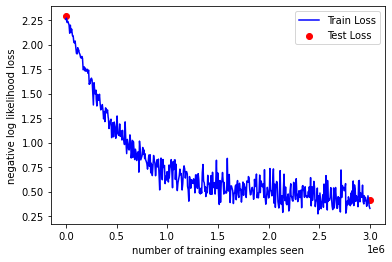

In [12]:
run(
    device_name="cpu",
    input_size=784,
    hidden_size=100,
    output_size=10,
    n_epochs=50,
)

## GPU (CUDA)


    DEVICE: cuda
    EPOCHS: 50
    INPUT_SIZE: 784
    HIDDEN_SIZE: 100
    OUTPUT_SIZE: 10
    ACTIVATION_FUNCTION: <function log_softmax at 0x7fe4f9626cb0>
    LOSS_FUNCTION: <function nll_loss at 0x7fe4f9628a70>
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3247, Accuracy: 7817/60000 (13%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317977
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.313468
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.302403
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.258238
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.267182
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.238422
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.223814
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.217035
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.181973
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.179860
Training Time (in minutes) = 0.13284643491109213
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.141214
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.158468
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.118147
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.096023
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.173748
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.115519
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.073875
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.073166
Train 

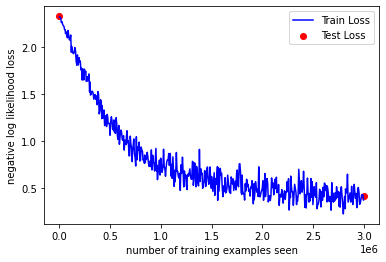

In [13]:
run(
    device_name="cuda",
    input_size=784,
    hidden_size=100,
    output_size=10,
    n_epochs=50,
)

## Hidden Layers


    DEVICE: cuda
    EPOCHS: 50
    INPUT_SIZE: 784
    HIDDEN_SIZE: 200
    OUTPUT_SIZE: 10
    ACTIVATION_FUNCTION: <function log_softmax at 0x7fe4f9626cb0>
    LOSS_FUNCTION: <function nll_loss at 0x7fe4f9628a70>
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3037, Accuracy: 7894/60000 (13%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303077
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.314821
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.260691
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.253906
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.178637
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.206037
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.221868
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.132839
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.134195
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.126660
Training Time (in minutes) = 0.13025387128194174
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.170240
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.108578
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.086602
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.076175
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.055019
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.057362
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.986612
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.994876
Train 

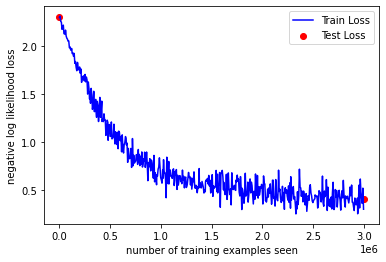

In [14]:
run(
    device_name="cuda",
    input_size=784,
    hidden_size=200,
    output_size=10
)


    DEVICE: cuda
    EPOCHS: 50
    INPUT_SIZE: 784
    HIDDEN_SIZE: 784
    OUTPUT_SIZE: 10
    ACTIVATION_FUNCTION: <function log_softmax at 0x7fe4f9626cb0>
    LOSS_FUNCTION: <function nll_loss at 0x7fe4f9628a70>
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3293, Accuracy: 5201/60000 (9%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.345998
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.320665
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.300103
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.223184
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.178513
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.237527
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.111921
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.136451
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.103185
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.083886
Training Time (in minutes) = 0.13166114886601765
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.061442
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.045053
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.021649
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.963594
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.983808
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.941084
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.937595
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.918994
Train E

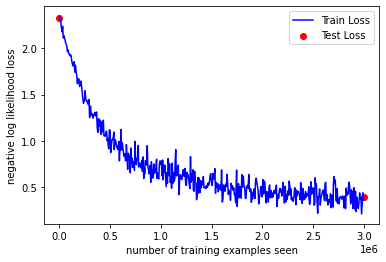

In [15]:
run(
    device_name="cuda",
    input_size=784,
    hidden_size=784,
    output_size=10
)

## Softmax


    DEVICE: cuda
    EPOCHS: 50
    INPUT_SIZE: 784
    HIDDEN_SIZE: 100
    OUTPUT_SIZE: 10
    ACTIVATION_FUNCTION: <function softmax at 0x7fe4f9626c20>
    LOSS_FUNCTION: CrossEntropyLoss()
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3936, Accuracy: 2231/60000 (4%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.382319
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.391615
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.371395
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.339087
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.270477
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.310688
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.292004
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.297122
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.259944
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.207328
Training Time (in minutes) = 0.13272602160771688
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.214514
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.173676
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.195762
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.226755
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.157314
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.128198
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.131693
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.096447
Train E

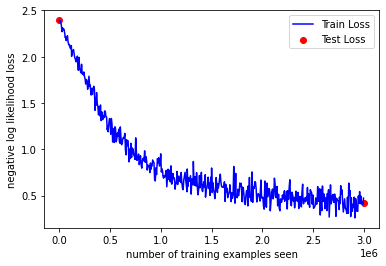

In [16]:
run(
    device_name="cuda",
    input_size=784,
    hidden_size=100,
    output_size=10,
    activation_function=F.softmax,
    loss_function=torch.nn.CrossEntropyLoss()
)